In [5]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv
import seaborn as sns

# Process Information Taken from Raw Files

## Import our Previously Extracted Data

In [6]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [7]:
subject_dataframes = [] # Initialize our dataframe array

for x in tqdm(record_list): # Extract our dataframes from the CSVs we saved previously
    subject_dataframes.append(pd.read_csv('mit-bih-dataframes/'+x+'.csv', index_col=0))
            # 'index_col=0' loads the index that is saved into the csv as the index rather than another column

100%|██████████| 23/23 [03:15<00:00,  8.51s/it]


In [8]:

# Now we get the indexes of the R-Peaks from our dataframes
qrs = [] # Initialize the array that will hold our list of R-Peaks for each subject

for subject in tqdm(subject_dataframes): # Load each subject
    qrs.append([idx for idx, x in enumerate(subject['R-Peak']) if x]) # Then we use list comprehension to get our r peaks for each subject
                                                                # Recall, the indices that the R-Peak column is true is where there is an r-peak
                                                                # So, we iterate through and identify which indices that is for each subject

100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


In [10]:
#print(subject_dataframes[1])
print(qrs[1])

[136, 276, 416, 557, 696, 834, 975, 1115, 1253, 1399, 1537, 1678, 1819, 1957, 2100, 2243, 2382, 2523, 2662, 2800, 2942, 3083, 3220, 3361, 3501, 3638, 3780, 3918, 4056, 4198, 4339, 4475, 4617, 4757, 4894, 5032, 5173, 5312, 5450, 5588, 5730, 5870, 6007, 6150, 6292, 6429, 6569, 6711, 6847, 6988, 7130, 7270, 7407, 7548, 7687, 7824, 7967, 8109, 8247, 8391, 8529, 8666, 8808, 8949, 9087, 9229, 9369, 9508, 9652, 9792, 9932, 10073, 10210, 10349, 10492, 10630, 10768, 10908, 11051, 11189, 11329, 11471, 11610, 11750, 11894, 12036, 12173, 12312, 12454, 12595, 12732, 12870, 13007, 13147, 13288, 13427, 13565, 13705, 13843, 13984, 14125, 14262, 14399, 14539, 14678, 14816, 14956, 15096, 15235, 15374, 15519, 15662, 15805, 15945, 16089, 16236, 16382, 16525, 16670, 16815, 16954, 17096, 17240, 17381, 17522, 17663, 17805, 17942, 18084, 18225, 18369, 18508, 18651, 18795, 18940, 19078, 19219, 19361, 19503, 19639, 19780, 19919, 20057, 20201, 20345, 20484, 20626, 20764, 20903, 21043, 21186, 21326, 21463, 21607,

## Extract RR-Intervals

In 2019, all of our developed variables were based on RR-Intervals, or the distance between adjacent R-Peaks. So, that is the first thing we extract 

In [9]:
rr_ints = [] # Initialize the array that will hold all of our subjects' RR-Intervals

# Then we want to Go through all of our data that holds our R-Peaks [That will be the qrs array]
# Iterating through that we want to extract the interval between each peak. 
# My suggested format is: 
"""
for each subject:
    for each rpeak sample_num in my current subject:
        subject_rrinterval.append( rpeak sample_num - the sample_num before it)
"""
for subject in tqdm(qrs):
    temp_array = []
    for index, rpeak in enumerate(subject):
        if index != 0:
            temp_array.append(rpeak - subject[index-1])
    rr_ints.append(temp_array)
print(rr_ints[0])

100%|██████████| 23/23 [00:00<00:00, 64.46it/s]

[139, 158, 226, 145, 144, 239, 148, 149, 234, 212, 217, 202, 207, 206, 137, 135, 131, 94, 125, 117, 220, 224, 134, 146, 249, 139, 153, 234, 217, 221, 215, 205, 209, 141, 139, 123, 94, 120, 104, 95, 115, 97, 166, 123, 74, 123, 109, 83, 88, 122, 149, 100, 141, 247, 221, 213, 132, 287, 146, 279, 144, 132, 233, 145, 180, 234, 145, 148, 231, 228, 202, 209, 208, 216, 200, 208, 204, 204, 207, 206, 207, 204, 214, 200, 206, 205, 205, 139, 129, 131, 120, 112, 133, 144, 108, 126, 244, 141, 192, 237, 134, 166, 240, 135, 138, 230, 137, 138, 119, 107, 189, 245, 138, 195, 237, 135, 190, 239, 136, 153, 242, 139, 132, 145, 125, 107, 109, 151, 247, 141, 149, 243, 219, 219, 217, 217, 212, 134, 137, 122, 102, 115, 141, 116, 89, 139, 108, 94, 110, 100, 140, 117, 80, 59, 173, 241, 134, 296, 136, 140, 238, 288, 242, 138, 153, 238, 138, 154, 234, 138, 151, 234, 139, 154, 235, 209, 209, 205, 133, 144, 235, 138, 165, 233, 136, 168, 233, 208, 132, 159, 231, 138, 133, 304, 240, 136, 190, 237, 139, 218, 277, 236, 

In [10]:
rr_timeints = []
for subject in rr_ints:
    subject_time = []
    for interval in subject:
        time = interval/250
        subject_time.append(time)
    rr_timeints.append(subject_time)
    
#print(rr_timeints[0])

In [39]:
#temp_sum = 0
#data_list = []
#for subject in rr_ints:
#    temp_list = []
#    for index, position in enumerate(subject):
#        temp_int = index + 1
#        if temp_int % 250 == 0:
#            temp_list.append(temp_sum/250)
#            temp_sum = 0
#        else:
#            temp_sum += position
#    data_list.append(temp_list)
#
#print(data_list[0])
print('hi')

hi


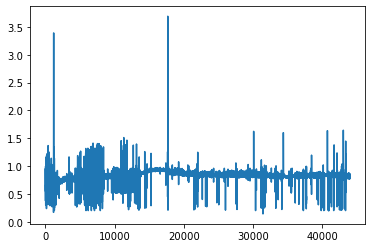

In [60]:
#sns.lineplot(data=rr_timeints[0], hue_norm=afib_arr[3:30000], hue=red)
plt.plot(rr_timeints[0])

In [34]:
#from Tutorial_Extract_MIT-BIH import atr_labels
df = pd.DataFrame(
    {
        "Interval": rr_timeints[0],
        "R-Peak": qrs[0][1:],
        "Afib": subject_dataframes[0]['AFIB'][qrs[0][1:]],
        "Rhythm":
    }
)

df

,Interval,R-Peak,Afib
200,0.556,200,False
358,0.632,358,False
584,0.904,584,False
729,0.580,729,False
873,0.576,873,False
...,...,...,...
8999121,0.828,8999121,False
8999327,0.824,8999327,False
8999531,0.816,8999531,False
8999734,0.812,8999734,False


In [104]:
#subject_dataframes[0]['R-Peak'][qrs[0][0]]
#subject_dataframes[0]
afib_arr = []
normal_arr = []
other_arr = []
rhythm_arr = []
for index, afib in enumerate(subject_dataframes[0]["AFIB"]):
    if index in qrs[0] and afib:
        afib_arr.append(index)
for index, normal in enumerate(subject_dataframes[0]["Normal"][qrs[0]]):
    if normal:
        normal_arr.append(index)
for index, other in enumerate(subject_dataframes[0]["Other"][qrs[0]]):
    if other:
        other_arr.append(index)
        

rhythm_arr.append(afib_arr)
rhythm_arr.append(normal_arr)
rhythm_arr.append(other_arr)

#rhythm_arr.sort()

rhythm_arr

142105it [01:20, 1759.60it/s]


KeyboardInterrupt: 

In [ ]:
#subject_dataframes[0]['AFIB'][qrs[0]]
#subject_dataframes[0]["AFIB"][qrs[0]]
#subject_dataframes[0].loc(qrs[0],)
#print(normal_arr)
#rhythm_arr = []
#print(qrs[0])
print(afib_arr)

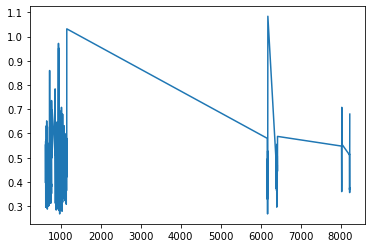

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

plt.plot(afib_arr, afib_time)
plt.show()

## Save the RR-Intervals 

In [ ]:
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .CSV

## What else to extract - some good places to start

- [Moody, 1983 - A new method for detecting atrial fibrillation using R-R intervals.](http://ecg.mit.edu/george/publications/afib-cinc-1983.pdf)
- [Lake, 2010 - Accurate estimation of entropy in very short physiological time series: the problem of atrial fibrillation detection in implanted ventricular devices](https://journals.physiology.org/doi/full/10.1152/ajpheart.00561.2010)
- [Rubio, 2011 - Estudio comparativo de algoritmos para la deteccion de la fibrilacion auricular](https://academica-e.unavarra.es/bitstream/handle/2454/4136/577570.pdf?sequence=1&isAllowed=y)
- [Ghodrati, 2008 - Statistical analysis of RR interval irregularities for detection of atrial fibrillation](https://ieeexplore.ieee.org/document/4749227)
- [Young, 1999 - A comparative study of a hidden Markov model detector for atrial fibrillation](https://ieeexplore.ieee.org/abstract/document/788166)